In [1]:
!pip install neuralforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.8/141.8 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 60.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 100.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATSx
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, MSE, MAE
from neuralforecast.tsdataset import TimeSeriesDataset, TimeSeriesLoader
from numpy.random import seed
from random import randrange
from neuralforecast.losses.numpy import rmse, mape
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic

In [3]:
df = pd.read_excel("GDAXI - kopie.xlsx",index_col='Date',parse_dates=True)

In [4]:
df.reset_index(inplace=True)
df.rename(columns={'Date':'ds'}, inplace=True)
df.rename(columns={'RV':'y'}, inplace=True)
df["unique_id"]="airplane1"
train = df.iloc[:int(len(df['y'])*0.8)]
test = df.iloc[int(len(df['y'])*0.8):]
validation_length=int(len(df['y'])*0.8)-int(len(df['y'])*0.6)

In [5]:
df.head()

,ds,wasserstein_dists_2D,y,VIX,unique_id
0,2004-05-25,0.047309,0.008169,15.960000,airplane1
1,2004-05-26,0.043802,0.012228,15.970000,airplane1
2,2004-05-27,0.051132,0.007634,15.280000,airplane1
3,2004-05-28,0.047027,0.008074,15.500000,airplane1
4,2004-06-01,0.041049,0.010822,16.299999,airplane1


In [6]:
n_inputs = [5,10,21,63,84,126,252]
mlp_units = [[[712, 712], [712, 712]],[[512, 512], [512, 512]],[[250, 250], [250, 250]],[[100, 100], [100, 100]]]
epochs=[25,50,100,150,250,350,450,550,750]
learning_rate=[0.0005,0.0001,0.00005,0.00001]
num_lr_decays=[5,3,2,1]
dropouts=[0,0.2,0.3,0.4,0.5]
scaler_type=["robust","standard",'minmax']
stack_types=[['identity','identity'],['trend','identity'],['seasonality','identity'],['trend','seasonality']]
n_harmonics=[0,0,1,1]
n_blocks=[[1, 1],[2, 2],[3, 3],[5, 5]]
n_polynomials=[0,1,0,1]
losses=[MSE(),MAE(),MQLoss(level=[90]),MQLoss(level=[80, 90]),MQLoss(level=[95]), MQLoss(level=[75])]
RMSE = []
Accuracy = []

# Hyperparameter Search

In [ ]:
for m in range (5):
  i=randrange(7)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX','wasserstein_dists_2D'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 96944307


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 124195984


Epoch: 450 | Inputs: 126 | MLP units: [[512, 512], [512, 512]] | Loss: 4 | Scaler Type: minmax
Stack Types: ['trend', 'identity'] | Learning Rate: 5e-05 | Block: [3, 3]
RMSE: 0.006505751472076844 | QLIKE: 0.1292096516567812


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 29587322


Epoch: 550 | Inputs: 63 | MLP units: [[712, 712], [712, 712]] | Loss: 4 | Scaler Type: robust
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0001 | Block: [2, 2]
RMSE: 0.005938407133894368 | QLIKE: 0.12636624913082517


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 78609197


Epoch: 25 | Inputs: 252 | MLP units: [[100, 100], [100, 100]] | Loss: 0 | Scaler Type: robust
Stack Types: ['trend', 'seasonality'] | Learning Rate: 1e-05 | Block: [2, 2]
RMSE: 0.007316359230677808 | QLIKE: 0.2959718348929143


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 56672695


Epoch: 450 | Inputs: 126 | MLP units: [[250, 250], [250, 250]] | Loss: 3 | Scaler Type: standard
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0001 | Block: [2, 2]
RMSE: 0.006313935822687496 | QLIKE: nan


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 50 | Inputs: 252 | MLP units: [[250, 250], [250, 250]] | Loss: 2 | Scaler Type: robust
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0001 | Block: [5, 5]
RMSE: 0.007142573110026775 | QLIKE: 0.2046885426220328


In [ ]:
for m in range (5):
  i=randrange(7)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX','wasserstein_dists_2D'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 5209


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 110791955


Epoch: 750 | Inputs: 21 | MLP units: [[250, 250], [250, 250]] | Loss: 2 | Scaler Type: minmax
Stack Types: ['trend', 'identity'] | Learning Rate: 5e-05 | Block: [3, 3]
RMSE: 0.00605925624369569 | QLIKE: 0.1254183709065706


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 62766648


Epoch: 50 | Inputs: 84 | MLP units: [[250, 250], [250, 250]] | Loss: 0 | Scaler Type: standard
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0005 | Block: [1, 1]
RMSE: 0.007025397570076596 | QLIKE: 0.17835576928246466


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 106281454


Epoch: 250 | Inputs: 10 | MLP units: [[512, 512], [512, 512]] | Loss: 5 | Scaler Type: standard
Stack Types: ['seasonality', 'identity'] | Learning Rate: 5e-05 | Block: [2, 2]
RMSE: 0.006135367055705584 | QLIKE: 0.1302856871615404


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 18625496


Epoch: 750 | Inputs: 63 | MLP units: [[100, 100], [100, 100]] | Loss: 4 | Scaler Type: minmax
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0005 | Block: [2, 2]
RMSE: 0.006097238619562274 | QLIKE: 0.1685997659248839


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 250 | Inputs: 126 | MLP units: [[512, 512], [512, 512]] | Loss: 3 | Scaler Type: standard
Stack Types: ['seasonality', 'identity'] | Learning Rate: 5e-05 | Block: [2, 2]
RMSE: 0.0065014045416899495 | QLIKE: nan


In [ ]:
for m in range (5):
  i=randrange(7)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX','wasserstein_dists_2D'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 11735975


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 122319252


Epoch: 350 | Inputs: 5 | MLP units: [[512, 512], [512, 512]] | Loss: 5 | Scaler Type: standard
Stack Types: ['seasonality', 'identity'] | Learning Rate: 5e-05 | Block: [5, 5]
RMSE: 0.006704320000703363 | QLIKE: 0.14003854359830245


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 48843416


Epoch: 450 | Inputs: 10 | MLP units: [[512, 512], [512, 512]] | Loss: 3 | Scaler Type: robust
Stack Types: ['identity', 'identity'] | Learning Rate: 0.0001 | Block: [3, 3]
RMSE: 0.006263949282661358 | QLIKE: 0.13988820725492504


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 64611123


Epoch: 150 | Inputs: 126 | MLP units: [[712, 712], [712, 712]] | Loss: 4 | Scaler Type: minmax
Stack Types: ['identity', 'identity'] | Learning Rate: 5e-05 | Block: [1, 1]
RMSE: 0.007163829433447831 | QLIKE: 0.22407448694793006


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 104791924


Epoch: 250 | Inputs: 10 | MLP units: [[100, 100], [100, 100]] | Loss: 3 | Scaler Type: minmax
Stack Types: ['trend', 'identity'] | Learning Rate: 5e-05 | Block: [2, 2]
RMSE: 0.007067470903055716 | QLIKE: 0.18465672531882282


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 25 | Inputs: 84 | MLP units: [[712, 712], [712, 712]] | Loss: 5 | Scaler Type: standard
Stack Types: ['identity', 'identity'] | Learning Rate: 0.0005 | Block: [1, 1]
RMSE: 0.007131791081011558 | QLIKE: 0.18643336863059345


In [ ]:
for m in range (5):
  i=randrange(7)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX','wasserstein_dists_2D'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 10794816


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 100159833


Epoch: 250 | Inputs: 10 | MLP units: [[100, 100], [100, 100]] | Loss: 3 | Scaler Type: robust
Stack Types: ['identity', 'identity'] | Learning Rate: 1e-05 | Block: [5, 5]
RMSE: 0.007197079020186454 | QLIKE: 0.19740783117355679


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 10593070


Epoch: 550 | Inputs: 10 | MLP units: [[512, 512], [512, 512]] | Loss: 3 | Scaler Type: minmax
Stack Types: ['seasonality', 'identity'] | Learning Rate: 1e-05 | Block: [1, 1]
RMSE: 0.0062780041939355605 | QLIKE: 0.13067185178583707


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 122784902


Epoch: 50 | Inputs: 252 | MLP units: [[250, 250], [250, 250]] | Loss: 1 | Scaler Type: standard
Stack Types: ['trend', 'seasonality'] | Learning Rate: 1e-05 | Block: [2, 2]
RMSE: 0.007254465312683529 | QLIKE: 0.2023062155892367


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 98649809


Epoch: 50 | Inputs: 10 | MLP units: [[712, 712], [712, 712]] | Loss: 3 | Scaler Type: standard
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0001 | Block: [1, 1]
RMSE: 0.0065142149622550985 | QLIKE: 0.1560793925602897


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 50 | Inputs: 126 | MLP units: [[512, 512], [512, 512]] | Loss: 3 | Scaler Type: minmax
Stack Types: ['identity', 'identity'] | Learning Rate: 1e-05 | Block: [2, 2]
RMSE: 0.00737092286121836 | QLIKE: nan


In [ ]:
for m in range (5):
  i=randrange(7)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX','wasserstein_dists_2D'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 100296835


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 108571214


Epoch: 550 | Inputs: 252 | MLP units: [[100, 100], [100, 100]] | Loss: 1 | Scaler Type: minmax
Stack Types: ['identity', 'identity'] | Learning Rate: 0.0001 | Block: [3, 3]
RMSE: 0.007146361433360704 | QLIKE: nan


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 8907073


Epoch: 750 | Inputs: 21 | MLP units: [[100, 100], [100, 100]] | Loss: 1 | Scaler Type: standard
Stack Types: ['trend', 'identity'] | Learning Rate: 1e-05 | Block: [5, 5]
RMSE: 0.006546899608264903 | QLIKE: 0.15733146140406168


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 103326476


Epoch: 100 | Inputs: 126 | MLP units: [[100, 100], [100, 100]] | Loss: 1 | Scaler Type: robust
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0001 | Block: [5, 5]
RMSE: 0.007014106615283019 | QLIKE: 0.19570776668550693


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 25 | Inputs: 10 | MLP units: [[250, 250], [250, 250]] | Loss: 5 | Scaler Type: robust
Stack Types: ['trend', 'seasonality'] | Learning Rate: 1e-05 | Block: [3, 3]
RMSE: 0.007221297891159434 | QLIKE: 0.19136968979779503


In [ ]:
for m in range (5):
  i=randrange(7)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX','wasserstein_dists_2D'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 120593185


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 71178863


Epoch: 450 | Inputs: 10 | MLP units: [[512, 512], [512, 512]] | Loss: 5 | Scaler Type: minmax
Stack Types: ['identity', 'identity'] | Learning Rate: 1e-05 | Block: [2, 2]
RMSE: 0.006168395206283958 | QLIKE: 0.12863992620025158


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 60930352


Epoch: 350 | Inputs: 252 | MLP units: [[250, 250], [250, 250]] | Loss: 3 | Scaler Type: standard
Stack Types: ['trend', 'seasonality'] | Learning Rate: 5e-05 | Block: [2, 2]
RMSE: 0.006890006926303093 | QLIKE: 0.18430202573440221


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 114934832


Epoch: 100 | Inputs: 84 | MLP units: [[100, 100], [100, 100]] | Loss: 2 | Scaler Type: robust
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0005 | Block: [1, 1]
RMSE: 0.007163665870234387 | QLIKE: 0.19825768477116776


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 21239632


Epoch: 450 | Inputs: 5 | MLP units: [[100, 100], [100, 100]] | Loss: 0 | Scaler Type: standard
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0001 | Block: [2, 2]
RMSE: 0.0069028754701430245 | QLIKE: 0.1340936220840636


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 250 | Inputs: 63 | MLP units: [[100, 100], [100, 100]] | Loss: 4 | Scaler Type: minmax
Stack Types: ['trend', 'identity'] | Learning Rate: 5e-05 | Block: [3, 3]
RMSE: 0.00707708336997058 | QLIKE: 0.18457289836876883


In [ ]:
for m in range (5):
  i=randrange(7)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX','wasserstein_dists_2D'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 85028294


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 92105761


Epoch: 100 | Inputs: 10 | MLP units: [[712, 712], [712, 712]] | Loss: 3 | Scaler Type: robust
Stack Types: ['trend', 'identity'] | Learning Rate: 1e-05 | Block: [2, 2]
RMSE: 0.0070415102940572525 | QLIKE: 0.1818562094060001


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 2247421


Epoch: 350 | Inputs: 126 | MLP units: [[100, 100], [100, 100]] | Loss: 5 | Scaler Type: robust
Stack Types: ['identity', 'identity'] | Learning Rate: 5e-05 | Block: [3, 3]
RMSE: 0.007099726575606526 | QLIKE: 0.18447208295211856


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 25569167


Epoch: 250 | Inputs: 63 | MLP units: [[250, 250], [250, 250]] | Loss: 0 | Scaler Type: standard
Stack Types: ['trend', 'identity'] | Learning Rate: 1e-05 | Block: [1, 1]
RMSE: 0.007183907722315482 | QLIKE: 0.18807556620072438


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 108204388


Epoch: 50 | Inputs: 63 | MLP units: [[512, 512], [512, 512]] | Loss: 2 | Scaler Type: standard
Stack Types: ['trend', 'identity'] | Learning Rate: 5e-05 | Block: [3, 3]
RMSE: 0.0070369112832879685 | QLIKE: 0.18091198322039664


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 100 | Inputs: 21 | MLP units: [[250, 250], [250, 250]] | Loss: 5 | Scaler Type: minmax
Stack Types: ['trend', 'identity'] | Learning Rate: 5e-05 | Block: [5, 5]
RMSE: 0.006605254537132629 | QLIKE: 0.16436810743905522


In [ ]:
for m in range (5):
  i=randrange(6)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX','wasserstein_dists_2D'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 123531919


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 5998526


Epoch: 50 | Inputs: 63 | MLP units: [[100, 100], [100, 100]] | Loss: 3 | Scaler Type: robust
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0005 | Block: [5, 5]
RMSE: 0.00698826378668206 | QLIKE: 0.1788102076588258


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 65520947


Epoch: 250 | Inputs: 21 | MLP units: [[712, 712], [712, 712]] | Loss: 4 | Scaler Type: minmax
Stack Types: ['identity', 'identity'] | Learning Rate: 1e-05 | Block: [5, 5]
RMSE: 0.006218152005795087 | QLIKE: 0.1261949312953485


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 99572920


Epoch: 450 | Inputs: 10 | MLP units: [[712, 712], [712, 712]] | Loss: 0 | Scaler Type: robust
Stack Types: ['trend', 'seasonality'] | Learning Rate: 5e-05 | Block: [1, 1]
RMSE: 0.006547597678045862 | QLIKE: 0.13273485448868488


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 123594357


Epoch: 450 | Inputs: 126 | MLP units: [[512, 512], [512, 512]] | Loss: 1 | Scaler Type: robust
Stack Types: ['seasonality', 'identity'] | Learning Rate: 1e-05 | Block: [3, 3]
RMSE: 0.0066625409912996775 | QLIKE: 0.17483225745308742


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 450 | Inputs: 21 | MLP units: [[100, 100], [100, 100]] | Loss: 5 | Scaler Type: standard
Stack Types: ['seasonality', 'identity'] | Learning Rate: 5e-05 | Block: [5, 5]
RMSE: 0.00613536026892227 | QLIKE: 0.1311329198618444


In [ ]:
for m in range (5):
  i=randrange(6)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX','wasserstein_dists_2D'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 77245957


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 42345117


Epoch: 25 | Inputs: 126 | MLP units: [[100, 100], [100, 100]] | Loss: 4 | Scaler Type: robust
Stack Types: ['identity', 'identity'] | Learning Rate: 1e-05 | Block: [2, 2]
RMSE: 0.007247904311799875 | QLIKE: 0.1968439571903502


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 93477412


Epoch: 25 | Inputs: 5 | MLP units: [[100, 100], [100, 100]] | Loss: 0 | Scaler Type: standard
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0005 | Block: [2, 2]
RMSE: 0.006922342780047605 | QLIKE: 0.15835450391418765


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 69952004


Epoch: 150 | Inputs: 63 | MLP units: [[712, 712], [712, 712]] | Loss: 2 | Scaler Type: minmax
Stack Types: ['identity', 'identity'] | Learning Rate: 0.0001 | Block: [5, 5]
RMSE: 0.006290656031676015 | QLIKE: nan


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 123148482


Epoch: 350 | Inputs: 21 | MLP units: [[100, 100], [100, 100]] | Loss: 2 | Scaler Type: standard
Stack Types: ['trend', 'seasonality'] | Learning Rate: 5e-05 | Block: [5, 5]
RMSE: 0.006304851052974514 | QLIKE: 0.1408251860644358


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 25 | Inputs: 126 | MLP units: [[512, 512], [512, 512]] | Loss: 0 | Scaler Type: standard
Stack Types: ['identity', 'identity'] | Learning Rate: 1e-05 | Block: [2, 2]
RMSE: 0.007238573049119977 | QLIKE: 0.19867325990318221


5209

Epoch: 750 | Inputs: 21 | MLP units: [[250, 250], [250, 250]] | Loss: 2 | Scaler Type: minmax
Stack Types: ['trend', 'identity'] | Learning Rate: 5e-05 | Block: [3, 3]
RMSE: 0.00605925624369569 | QLIKE: 0.1254183709065706

In [ ]:
for m in range (5):
  random_seed=randrange(129228148)
  model = NBEATSx(h=5, input_size=21,
                loss=losses[2],
                scaler_type='minmax',
                learning_rate= 0.00005,
                stack_types=['trend','identity'],
                n_blocks=[3,3],
                mlp_units= [[250, 250], [250, 250]],
                windows_batch_size=60,
                num_lr_decays=2,
                val_check_steps=100,
                n_harmonics=0, n_polynomials=1,
                hist_exog_list=['VIX','wasserstein_dists_2D'],
                max_steps=750,
                early_stop_patience_steps=1,
                random_seed=random_seed
                )
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Seed: {random_seed}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}") 

INFO:lightning_fabric.utilities.seed:Global seed set to 83690155


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 23513998


Seed: 83690155
RMSE: 0.006261721943628557 | QLIKE: 0.13259696829694495


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 50564085


Seed: 23513998
RMSE: 0.00606741449651572 | QLIKE: 0.1243282391327163


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 118764873


Seed: 50564085
RMSE: 0.006167193675646819 | QLIKE: 0.12092287051313441


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 33214415


Seed: 118764873
RMSE: 0.005994538178952659 | QLIKE: 0.12009153680579474


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Seed: 33214415
RMSE: 0.006037633740614337 | QLIKE: nan


In [ ]:
for m in range (5):
  random_seed=randrange(129228148)
  model = NBEATSx(h=5, input_size=21,
                loss=losses[2],
                scaler_type='minmax',
                learning_rate= 0.00005,
                stack_types=['trend','identity'],
                n_blocks=[3,3],
                mlp_units= [[250, 250], [250, 250]],
                windows_batch_size=60,
                num_lr_decays=2,
                val_check_steps=100,
                n_harmonics=0, n_polynomials=1,
                hist_exog_list=['VIX','wasserstein_dists_2D'],
                max_steps=750,
                early_stop_patience_steps=1,
                random_seed=random_seed
                )
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Seed: {random_seed}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}") 

INFO:lightning_fabric.utilities.seed:Global seed set to 24533839


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 41234001


Seed: 24533839
RMSE: 0.00613057191132667 | QLIKE: 0.12787038976877207


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 6725779


Seed: 41234001
RMSE: 0.006028426171321623 | QLIKE: 0.1278555397586511


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 82396633


Seed: 6725779
RMSE: 0.006166323736874681 | QLIKE: 0.12978082893709597


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 103073693


Seed: 82396633
RMSE: 0.006043315212549068 | QLIKE: 0.12619013624696063


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Seed: 103073693
RMSE: 0.006086286000355557 | QLIKE: 0.12276991433087105


In [ ]:
for m in range (5):
  random_seed=randrange(129228148)
  model = NBEATSx(h=5, input_size=21,
                loss=losses[2],
                scaler_type='minmax',
                learning_rate= 0.00005,
                stack_types=['trend','identity'],
                n_blocks=[3,3],
                mlp_units= [[250, 250], [250, 250]],
                windows_batch_size=60,
                num_lr_decays=2,
                val_check_steps=100,
                n_harmonics=0, n_polynomials=1,
                hist_exog_list=['VIX','wasserstein_dists_2D'],
                max_steps=750,
                early_stop_patience_steps=1,
                random_seed=random_seed
                )
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Seed: {random_seed}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}") 

INFO:lightning_fabric.utilities.seed:Global seed set to 45609361


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 31619282


Seed: 45609361
RMSE: 0.006019182710369041 | QLIKE: nan


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 39007160


Seed: 31619282
RMSE: 0.006064662302243604 | QLIKE: nan


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 69859959


Seed: 39007160
RMSE: 0.006073217721014873 | QLIKE: 0.12590538221118813


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 127842322


Seed: 69859959
RMSE: 0.006064409224167785 | QLIKE: 0.1254599027357604


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Seed: 127842322
RMSE: 0.006046887158537001 | QLIKE: nan


In [ ]:
for m in range (5):
  random_seed=randrange(129228148)
  model = NBEATSx(h=5, input_size=21,
                loss=losses[2],
                scaler_type='minmax',
                learning_rate= 0.00005,
                stack_types=['trend','identity'],
                n_blocks=[3,3],
                mlp_units= [[250, 250], [250, 250]],
                windows_batch_size=60,
                num_lr_decays=2,
                val_check_steps=100,
                n_harmonics=0, n_polynomials=1,
                hist_exog_list=['VIX','wasserstein_dists_2D'],
                max_steps=750,
                early_stop_patience_steps=1,
                random_seed=random_seed
                )
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Seed: {random_seed}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}") 

INFO:lightning_fabric.utilities.seed:Global seed set to 70447378


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 126692155


Seed: 70447378
RMSE: 0.006040706280305599 | QLIKE: 0.11891038759792798


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 40025246


Seed: 126692155
RMSE: 0.0060274814762477456 | QLIKE: 0.12077446662124205


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 70426004


Seed: 40025246
RMSE: 0.006078496635013472 | QLIKE: nan


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 48570255


Seed: 70426004
RMSE: 0.00607873913896441 | QLIKE: nan


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Seed: 48570255
RMSE: 0.0060340704754003795 | QLIKE: 0.11874715084755716


# H=5 Forecasts

In [12]:
RMSE=[]
Quasilikelihood=[]

In [8]:
test_length=len(df["y"])-int(len(df['y'])*0.8)

In [13]:
model = NBEATSx(h=5, input_size=21,
                loss=losses[2],
                scaler_type='minmax',
                learning_rate= 0.00005,
                stack_types=['trend','identity'],
                n_blocks=[3,3],
                mlp_units= [[250, 250], [250, 250]],
                windows_batch_size=60,
                num_lr_decays=2,
                val_check_steps=100,
                n_harmonics=0, n_polynomials=1,
                hist_exog_list=['VIX','wasserstein_dists_2D'],
                max_steps=750,
                early_stop_patience_steps=1,
                random_seed=48570255
                )
fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
forecasts = fcst.cross_validation(df=df,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=test_length-test_length%5,step_size=5)
forecasts = forecasts.dropna()
if "NBEATSx-median" not in list(forecasts.columns.values):
  Y_hat1=forecasts["NBEATSx"].values
else:
  Y_hat1=forecasts["NBEATSx-median"].values
Y_true=forecasts["y"].values
RMSE.append(np.sqrt(np.sum(((Y_true-Y_hat1)**2))/len(Y_true)))
Quasilikelihood.append(np.sum(Y_true/Y_hat1-np.log(Y_true/Y_hat1)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 48570255


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [14]:
print(f"RMSE: {round(np.mean(RMSE)*100,4)}%")
print(f"QLIKE: {round(np.mean(Quasilikelihood)*100,2)}%")

RMSE: 0.5599%
QLIKE: 9.46%


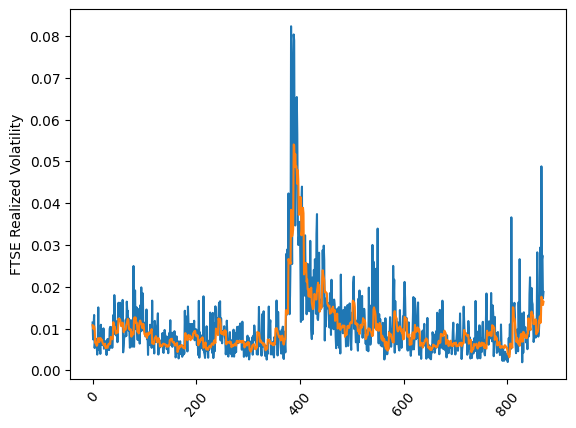

In [11]:
plt.plot(range(len(Y_true)), Y_true)
plt.plot(range(len(Y_true)), Y_hat1) 
plt.ylabel("FTSE Realized Volatility")
plt.xticks(rotation=50)
plt.show()

In [15]:
Data = {'Date': forecasts["ds"],
        'Actuals': Y_true,
        'Forecast with PH': Y_hat1
        }
df1=pd.DataFrame(data=Data)
df1.to_csv("Forecast with PH (NBEATSx).csv")